In [1]:
import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic
from jax import random
from jax import numpy as jnp
import pylab as plt
import numpy as np



/home/albert/miniconda3/envs/dsa_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:14: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# OU process

The SDE for the Ornstein-Uhlenbeck process, with long-term mean, is given by

$$
dx = \frac{1}{\tau} (\mu - x) dt + \sigma dW
$$

The equivalent GP kernel is given by

$$
k(x, x') = \frac{\sigma^2 \tau}{2} \exp\left(-\frac{|x - x'|}{\tau}\right)
$$

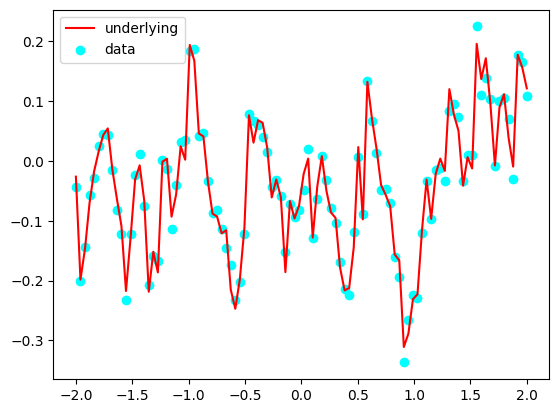

In [2]:
N = 100
num_outliers = int(0.15 * N)
np.random.seed(42)
X = jnp.linspace(-2., 2., N)[:, None]
dt = X[1, 0] - X[0, 0]
true_mu, true_tau, true_sigma = 0., 0.2, np.sqrt(0.2)
true_scale = true_tau
true_amplitude = true_sigma * jnp.sqrt(true_tau / 2.)
true_noise = 0.1 * true_amplitude
data_mu = jnp.zeros((N,))
prior_cov = tfpk.MaternOneHalf(amplitude=true_amplitude, length_scale=true_scale).matrix(X, X) + 1e-13 * jnp.eye(N)
Y = true_mu + jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_noise * random.normal(random.PRNGKey(1), shape=(N,))
plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.legend()
plt.show()


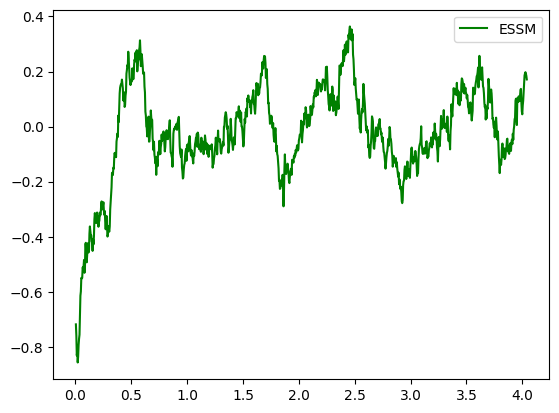

In [3]:

from essm_jax.essm import ExtendedStateSpaceModel


def transition_fn(z, t, t_next, map_estimate):
    dt = t_next - t
    sigma = map_estimate['sigma']
    tau = map_estimate['tau']
    mu = map_estimate['mu']
    x = z

    x_mean = x + (mu - x) / tau * dt
    x_std = sigma * jnp.sqrt(dt)

    return tfpd.MultivariateNormalDiag(loc=x_mean, scale_diag=x_std * jnp.ones_like(x))


def observation_fn(z, t, map_estimate):
    x = z
    uncert = map_estimate['uncert']
    return tfpd.MultivariateNormalDiag(loc=x, scale_diag=uncert * jnp.ones_like(x))


initial_state_prior = tfpd.MultivariateNormalDiag(loc=jnp.zeros((1,)), scale_diag=jnp.ones((1,)))

essm = ExtendedStateSpaceModel(
    transition_fn=transition_fn,
    observation_fn=observation_fn,
    initial_state_prior=initial_state_prior,
    dt=dt / 10
)

samples = essm.sample(
    random.PRNGKey(42), N * 10, {'tau': true_tau, 'sigma': true_sigma, 'mu': true_mu, 'uncert': true_noise},
)
plt.plot(samples.t, samples.latent[:, 0], c='green', label='ESSM')

plt.legend()
plt.show()

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 79181
samples: 1800
phantom samples: 0
likelihood evals / sample: 44.0
phantom fraction (%): 0.0%
--------
logZ=105.87 +- 0.24
max(logL)=114.55
H=-5.17
ESS=332
--------
mu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
mu: -0.033 +- 0.058 | -0.107 / -0.032 / 0.028 | -0.036 | -0.037
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 0.397 +- 0.046 | 0.339 / 0.398 / 0.455 | 0.44 | 0.444
--------
tau: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tau: 0.42 +- 0.37 | 0.14 / 0.24 / 0.98 | 0.13 | 0.13
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.021 +- 0.012 | 0.005 / 0.02 / 0.037 | 0.001 | 0.001
--------


/home/albert/miniconda3/envs/dsa_py/lib/python3.11/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


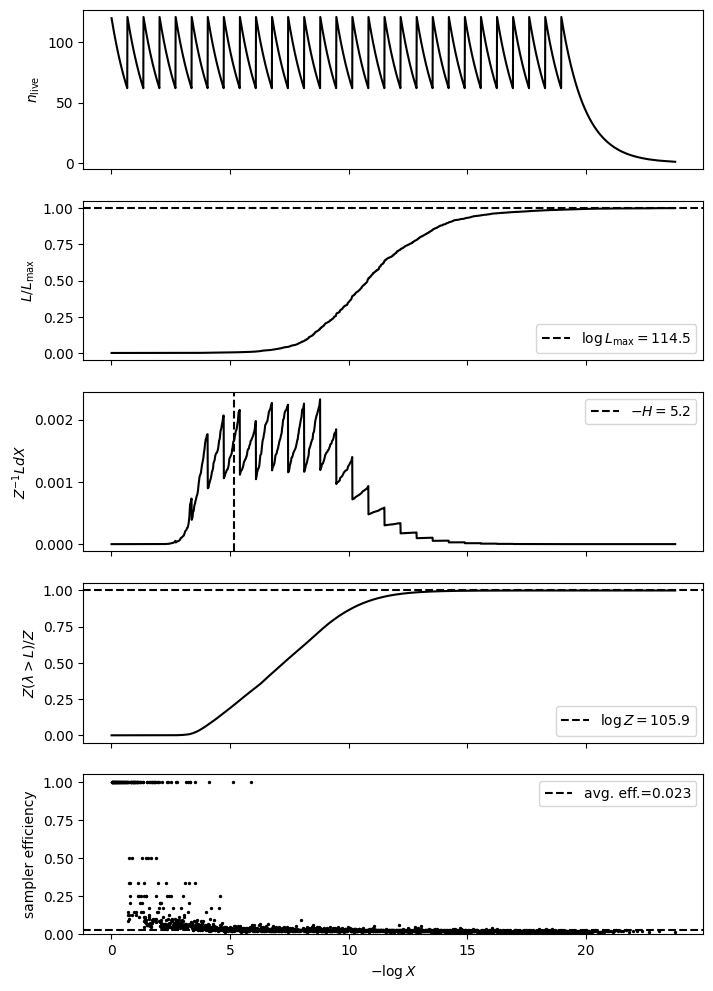

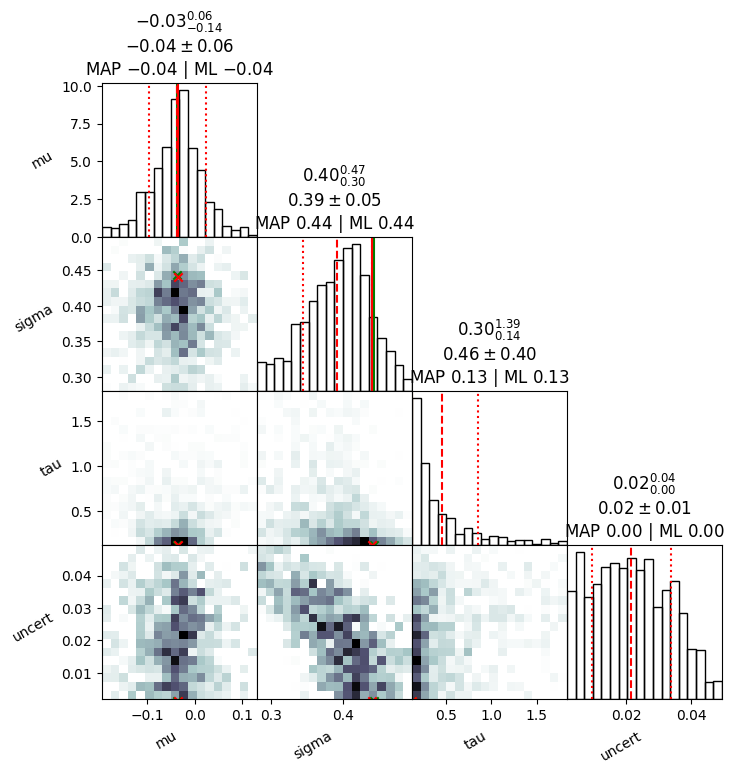

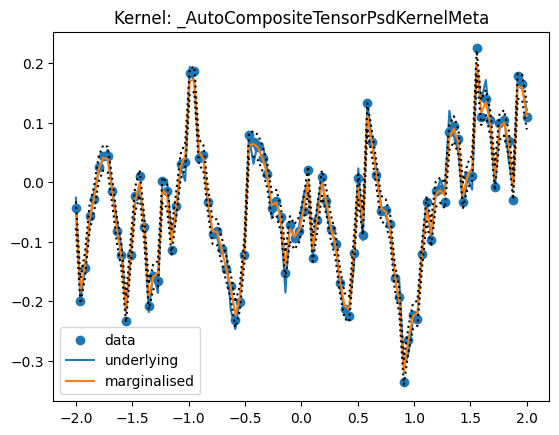

In [4]:


import jax
from jaxns import Prior, Model, NestedSampler

kernel = tfpk.MaternOneHalf

# X should be sorted
y_mean = jnp.mean(Y_obs)
y_std = jnp.std(Y_obs)
rmsd = jnp.sqrt(jnp.mean(jnp.square(jnp.diff(Y_obs, axis=0))))
mean_dt = jnp.mean(jnp.diff(X, axis=0))
min_tau = mean_dt * 3
max_tau = 0.5 * (jnp.max(X) - jnp.min(X))


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    return tfpd.MultivariateNormalTriL(mean, L).log_prob(x)


def log_likelihood(uncert, tau, sigma, mu):
    """
    P(Y|sigma, half_width) = N[Y, f, K]
    Args:
        sigma:
        l:

    Returns:

    """
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return log_normal(Y_obs, mu, K + data_cov)


def predict_f(uncert, tau, sigma, mu):
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs - mu)


def predict_fvar(uncert, tau, sigma, mu):
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))


# Build the model

def prior_model():
    tau = yield Prior(tfpd.Uniform(min_tau, max_tau), name='tau')
    uncert = yield Prior(tfpd.Uniform(true_noise * 0.1, true_noise * 10.), name='uncert')
    # amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    # sigma = sqrt(2 / tau) * amplitude
    mean_sigma = jnp.sqrt(2. / tau) * y_std / jnp.sqrt(dt)  # if dX is sigma dW then rms(dX/dt) = sigma
    sigma = yield Prior(tfpd.Exponential(1. / mean_sigma), name='sigma')
    mu = yield Prior(tfpd.Normal(y_mean, y_std), name='mu')
    return uncert, tau, sigma, mu


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = NestedSampler(model=model)

termination_reason, state = jax.jit(exact_ns)(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f)

predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                   results.ESS, predict_fvar)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(X[:, 0], Y, label='underlying')
plt.plot(X[:, 0], predict_f, label='marginalised')
plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()

logZ_m12, logZerr_m12 = results.log_Z_mean, results.log_Z_uncert

In [5]:
from typing import Dict
from jaxns import maximum_a_posteriori_point

map_estimate: Dict[str, jax.Array] = maximum_a_posteriori_point(results=results)
print(map_estimate)
map_estimate['tau'] = true_tau
map_estimate['sigma'] = true_sigma
map_estimate['mu'] = true_mu
map_estimate['uncert'] = true_noise
print(map_estimate)

{'mu': Array(-0.03576323, dtype=float64), 'sigma': Array(0.44039283, dtype=float64), 'tau': Array(0.13172916, dtype=float64), 'uncert': Array(0.00141641, dtype=float64)}
{'mu': 0.0, 'sigma': 0.4472135954999579, 'tau': 0.2, 'uncert': Array(0.01414214, dtype=float64)}


In [6]:
from essm_jax.essm import ExtendedStateSpaceModel


def transition_fn(z, t, t_next, map_estimate):
    dt = t_next - t
    sigma = map_estimate['sigma']
    tau = map_estimate['tau']
    mu = map_estimate['mu']
    x = z

    x_mean = x + (mu - x) / tau * dt
    x_std = sigma * jnp.sqrt(dt)
    return tfpd.MultivariateNormalDiag(loc=x_mean, scale_diag=x_std * jnp.ones_like(x))


def observation_fn(z, t, map_estimate):
    x = z
    uncert = map_estimate['uncert']
    return tfpd.MultivariateNormalDiag(loc=x, scale_diag=uncert * jnp.ones_like(x))


initial_state_prior = tfpd.MultivariateNormalDiag(loc=jnp.zeros((1,)), scale_diag=jnp.ones((1,)))

essm = ExtendedStateSpaceModel(
    transition_fn=transition_fn,
    observation_fn=observation_fn,
    initial_state_prior=initial_state_prior,
    dt=mean_dt
)

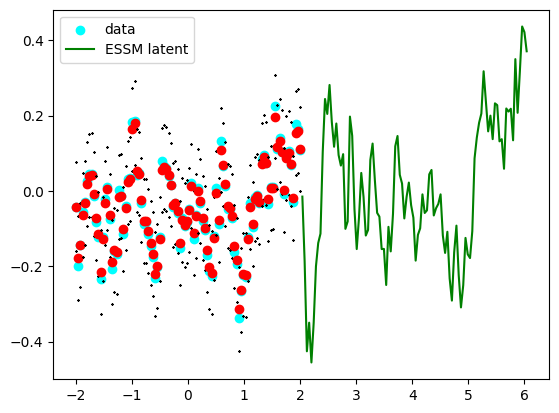

In [12]:
# plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
filter_state = essm.create_initial_filter_state(t0=jnp.min(X) - essm.dt)
for i in range(N):
    filter_state = essm.incremental_predict(filter_state, map_estimate)
    x_prior = filter_state.filtered_mean
    filter_state, _ = essm.incremental_update(filter_state, Y_obs[i], map_estimate)
    x_update = filter_state.filtered_mean
    # plt.scatter(filter_state.t, x_prior, c='blue')
    plt.scatter(filter_state.t, x_update, c='red')
    plt.scatter(filter_state.t, x_update + np.sqrt(filter_state.filtered_cov), c='black', marker='x', s=1)
    plt.scatter(filter_state.t, x_update - np.sqrt(filter_state.filtered_cov), c='black', marker='x', s=1)

samples = essm.forward_simulate(
    random.PRNGKey(42), N, filter_state, map_estimate
)
plt.plot(samples.t, samples.latent[:, 0], c='green', label='ESSM latent')

plt.legend()
plt.show()

